# Setting

In [0]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"young917","key":"38554d8ee11a16273014fb43b7fdc0a1"}'}

In [0]:
%ls -1ha kaggle.json

kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                               deadline             category            reward  teamCount  userHasEntered  
------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                  2030-01-01 00:00:00  Getting Started  Knowledge       3188           False  
titanic                                           2030-01-01 00:00:00  Getting Started  Knowledge      23920           False  
house-prices-advanced-regression-techniques       2030-01-01 00:00:00  Getting Started  Knowledge       5411            True  
connectx                                          2030-01-01 00:00:00  Getting Started  Knowledge        375           False  
nlp-getting-started                               2030-01-01 00:00:00  Getting Started      Kudos       1697            True  
competitive-data-science-predict-future-sales     2020-12-31 23:59:00  Playground           Kudos       7310   

In [0]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 21.6MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 57.0MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 61.2MB/s]


# **Data Load**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)
import spacy

plt.rcParams["figure.figsize"] = (15,5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [0]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
print(len(test))

3263


In [0]:
train.head(40)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


### final_text : concat keyword one hot encoding and target

In [0]:
df=pd.concat([train,test])
df.shape

(10876, 5)

In [0]:
df.fillna('', inplace=True)

#### Data Cleaning

In [0]:
from nltk.corpus import stopwords
from nltk.util import ngrams
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub

In [0]:
import nltk

nltk.download('stopwords')
stop=set(stopwords.words('english'))

punctuation = string.punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

In [0]:
df['original_text'] = df['text']

##### train과 test set에서 URL, html, 구두점을 삭제한다.

In [0]:
import re

# remove http
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_URL(x))

# remove HTML tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text']=df['text'].apply(lambda x : remove_html(x))

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['text']=df['text'].apply(lambda x : remove_emoji(x))

# https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
slang_abbrev_dict = {
    'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'B4N': 'Bye For Now',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': 'For What It\'s Worth',
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you',
    'ILU': 'I Love You',
    'IMHO': 'In My Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My Ass Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'OMG': 'Oh My God',
    'PITA': 'Pain In The Ass',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My Ass Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The Fuck',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait',
    '7K': 'Sick:-D Laugher'
}
def unslang(text):
    if text.upper() in slang_abbrev_dict.keys():
        return slang_abbrev_dict[text.upper()]
    else:
        return text
df['text']=df['text'].apply(lambda x : unslang(x))

# remove punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
df['text']=df['text'].apply(lambda x : remove_punct(x))

def tokenization(text):
    text = re.split('\W+', text)
    return text
df['text']=df['text'].apply(lambda x : tokenization(x.lower()))

In [0]:
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
df['text']=df['text'].apply(lambda x : remove_stopwords(x))

'''
def stemming(text):
    text = [stemmer.stem(word) for word in text]
    return text
df['text']=df['text'].apply(lambda x : stemming(x))
'''
df['text']=df['text'].apply(lambda x : ' '.join(x))

In [0]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
from nltk.stem import WordNetLemmatizer

# lemmatization keyword
def lemmentize(keyword):
    lmtzr = WordNetLemmatizer()
    keyword = lmtzr.lemmatize(keyword)
    keyword = lmtzr.lemmatize(keyword, 'v')
    return keyword
df['keyword'] = df['keyword'].apply(lambda x : lemmentize(x))

In [0]:
train[210:213]

,id,keyword,location,text,target
210,297,annihilated,"Horsemind, MI",THEY SHALL BE ANNIHILATED AND ALL OF THEIR PETEBESTS DESSICATED AND LAID BARE. THEN YOU SHALL KNEEL BEFORE ME.,0
211,298,annihilated,"New York, NY",Uribe just annihilated that baseball. #Mets,0
212,299,annihilated,Boksburg,@marksmaponyane Hey!Sundowns were annihilated in their previous meeting with Celtic.Indeed its an improvement.,0


In [0]:
df[210:213]

,id,keyword,location,text,target,original_text
210,297,annihilate,"Horsemind, MI",shall annihilated petebests dessicated laid bare shall kneel,0,THEY SHALL BE ANNIHILATED AND ALL OF THEIR PETEBESTS DESSICATED AND LAID BARE. THEN YOU SHALL KNEEL BEFORE ME.
211,298,annihilate,"New York, NY",uribe annihilated baseball mets,0,Uribe just annihilated that baseball. #Mets
212,299,annihilate,Boksburg,marksmaponyane heysundowns annihilated previous meeting celticindeed improvement,0,@marksmaponyane Hey!Sundowns were annihilated in their previous meeting with Celtic.Indeed its an improvement.


#### 빈도수 높은 keyword만 남기기

In [0]:
keywords_set = set()
count = 10
for index, row in df.iterrows():
    if '%20' in row['keyword']:
        keywords_set.add(repr(row['keyword']))
        if count:
            print(row['text'])
            count-=1
for k in keywords_set:
    print(k)  

experts france begin examining airplane debris found reunion island french air accident experts news
strict liability context airplane accident pilot error common component aviation cr 
crobscarla lifetime odds dying airplane accident 1 8015
experts france begin examining airplane debris found reunion island french air accident experts wedn 
alexalltimelow awwww theyre airplane accident theyre gonna die cuties good job
family members osama bin laden died airplane accident ironic mhmmm gov shit suspect
man goes airplane engine accident via youtube
horrible accident man died wings airplane 29072015 
cessna airplane accident ocampo coahuila mexico july 29 2015 killed four men including state coahuila government official
horrible accident man died wings airplane 29072015 watchthevideo 
'chemical%20emergency'
'suicide%20bombing'
'buildings%20on%20fire'
'heat%20wave'
'structural%20failure'
'wild%20fires'
'fire%20truck'
'blew%20up'
'loud%20bang'
'violent%20storm'
'war%20zone'
'blown%20up'
'bo

In [0]:
modified = {
'blown%20up': 'blow',
'blew%20up': 'blow',
'mass%20murderer': 'murder',
'natural%20disaster': 'disaster',
'mass%20murder': 'murder',
'oil%20spill': 'spill',
'body%20bagging': 'body bag',
'emergency%20services': 'emergency',
'buildings%20on%20fire': 'fire',
'violent%20storm': 'storm',
'war%20zone': 'war',
'forest%20fire': 'fire',
'structural%20failure': 'structural failure',
'nuclear%20disaster': 'nuclear',
'buildings%20burning': 'burn',
'suicide%20bomber': 'suicide bomb',
'bridge%20collapse': 'collapse',
'chemical%20emergency': 'emergency',
'cliff%20fall': 'fall',
'body%20bag': 'body bag',
'nuclear%20reactor': 'nuclear',
'suicide%20bomb': 'suicide bomb',
'first%20responders': 'first responder',
'forest%20fires': 'fire',
'suicide%20bombing': 'suicide bomb',
'bush%20fires': 'fire',
'loud%20bang': 'bang',
'emergency%20plan': 'emergency',
'body%20bags': 'body bag',
'airplane%20accident': 'accident',
'heat%20wave':'heat',
'dust%20storm': 'storm',
'fire%20truck': 'fire',
'burning%20buildings': 'burn',
'radiation%20emergency': 'radiation',
'wild%20fires': 'fire'
}

In [0]:
def modifying(keyword):
    if keyword in modified.keys():
        return modified[keyword]
    return keyword
df['keyword'] = df['keyword'].apply(lambda x : modifying(x))

In [0]:
keywords_freq = df.groupby(['keyword']).size().sort_values(ascending=False)

In [0]:
ls = keywords_freq[keywords_freq >90].index
print(ls)

Index(['fire', 'burn', 'emergency', 'drown', 'suicide bomb', 'body bag',
       'flood', 'scream', 'collapse', 'storm', 'bomb', 'deluge', 'survive',
       'casualty', 'nuclear', 'siren', 'panic', 'demolish', 'sink', 'collide',
       'crash', 'crush', 'riot', 'blow', 'death', 'obliterate', 'hijack',
       'fatality', 'accident', 'explode', 'weapon', 'wreck', 'evacuate',
       'electrocute', 'attack', 'quarantine', 'hostage', 'disaster', 'injury',
       'destroy', 'blaze', 'derail', 'murder'],
      dtype='object', name='keyword')


In [0]:
def use_only_frequent_keyword(keyword):
    if keyword not in ls:
        return ''
    return keyword
df['keyword'] = df['keyword'].apply(lambda x : use_only_frequent_keyword(x))

In [0]:
df[100:1000:100]

,id,keyword,location,text,target,original_text
100,144,accident,UK,norwaymfa bahrain police previously died road accident killed explosion,1,.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad
200,281,,VISIT MY YOUTUBE CHANNEL.,happening hatzolah ems ambulance responding dual sirens û,0,HAPPENING NOW - HATZOLAH EMS AMBULANCE RESPONDING WITH DUAL SIRENS ANDÛ_ https://t.co/SeK6MQ6NJF
300,442,,,shadow boxing apocalypse,1,Shadow boxing the apocalypse
400,577,,"Los Angeles, CA",owner chicagoarea gay bar admits arson scheme via theadvocatemag lgbt,0,Owner of Chicago-Area Gay Bar Admits to Arson Scheme http://t.co/0TSlQjOKvh via @theadvocatemag #LGBT
500,725,attack,"LEALMAN, FLORIDA",christian attacked muslims temple mount waving israeli flag via pamela geller,1,Christian Attacked by Muslims at the Temple Mount after Waving Israeli Flag via Pamela Geller - ... http://t.co/LHBZHWq4B9
600,868,,Across the Atlantic,breakingnews fedex longer willing transport research specimens potential bioter û,0,#BreakingNews http://t.co/gAN14PW9TG FedEx no longer willing to transport research specimens of potential bioterÛ_ http://t.co/5n4hUsewLy
700,1008,blaze,,bekahw thanks sweat bullets every time get blazing sun beating,0,@bekah__w thanks! I sweat bullets every time I get in with this blazing sun beating down on me.
800,1160,,Laventillemoorings,dotish blight car go right ahead mine,0,If you dotish to blight your car go right ahead. Once it's not mine.
900,1302,,Singapore,damn bloody hot,0,Damn bloody hot


### Remove Mislabeled
https://www.kaggle.com/rai555/real-or-not-nlp-huggingface-bert-pytorch

In [0]:
train_len = len(train)
print(train_len)
train = df[:train_len]
test = df[train_len:]

7613


In [0]:
# Remove the mislabelled tweets
incorrect_labels_df = train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
incorrect_labels_df = incorrect_labels_df[incorrect_labels_df['target'] > 1]
incorrect_texts = incorrect_labels_df.index.tolist()
train = train[~train.text.isin(incorrect_texts)]

In [0]:
print(len(train))

7357


## **Model**

In [0]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [0]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 2.8MB/s 


#### Encoding

In [0]:
# text -> tokens with padding
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [0]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 22.2 s, sys: 4.08 s, total: 26.3 s
Wall time: 46.6 s


In [0]:
import tokenization

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
train = train.sample(frac=1).reset_index(drop=True)

In [0]:
from sklearn.preprocessing import OneHotEncoder

def get_key_word_one_hot_encoding(data):
    encoder = OneHotEncoder()
    keywords_encoded, keywords_categories = data['keyword'].factorize()
    keywords_hot = encoder.fit_transform(keywords_encoded.reshape(-1,1))
    encoded = keywords_hot.toarray() # keyword answer
    return encoded

In [0]:
keyword_answers = get_key_word_one_hot_encoding(train)
keyword_answers = np.asarray(keyword_answers, np.float32)
print(keyword_answers.shape)

(7357, 44)


In [0]:
val_len = int(train_len*0.2)
val = train[-val_len:]
train = train[:-val_len]

In [0]:
print(len(val))
print(len(train))

1522
5835


In [0]:
train_keyword_answers = keyword_answers[:-val_len]
val_keyword_answers = keyword_answers[-val_len:]
print(val_keyword_answers.shape)

(1522, 44)


In [0]:
train_disaster_answers = train['target'].values
train_disaster_answers = np.asarray(train_disaster_answers, np.float32)

val_disaster_answers = val['target'].values
val_disaster_answers = np.asarray(val_disaster_answers, np.float32)

In [0]:
#check
print(train.shape)
print(train_disaster_answers.shape)
print(train_keyword_answers.shape)


print(val.shape)
print(val_disaster_answers.shape)
print(val_keyword_answers.shape)

(5835, 6)
(5835,)
(5835, 44)
(1522, 6)
(1522,)
(1522, 44)


In [0]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
val_input = bert_encode(val.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)

#### Build Model

In [0]:
EPOCHS = 30
INIT_LR = 2e-7

In [0]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]

    drop_out = tf.keras.layers.Dropout(0.5)(clf_output)

    out = Dense(43, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(drop_out)
    disaster_out = Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01), name="disaster_output")(out)

    keyword_out = Dense(44, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01), name="keyword_output")(drop_out)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[disaster_out, keyword_out])
    losses = {
        "disaster_output": "binary_crossentropy",
        "keyword_output": "categorical_crossentropy"
    }
    lossWeights = {
        "disaster_output": 0.65,
        "keyword_output": 0.35 }
    model.compile(optimizer=Adam(lr=INIT_LR, decay=INIT_LR / (EPOCHS*EPOCHS)), loss=losses, loss_weights=lossWeights, metrics=['accuracy'])
    
    return model

In [0]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [0]:
es = EarlyStopping(monitor='val_disaster_output_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_disaster_output_accuracy', mode='max', save_best_only=True)

In [0]:
%%time
train_history = model.fit(
    train_input, 
    {"disaster_output": train_disaster_answers, "keyword_output": train_keyword_answers },
    validation_data=(val_input, {"disaster_output": val_disaster_answers, "keyword_output": val_keyword_answers}),
    epochs=EPOCHS,
    batch_size=8,
    callbacks=[es, mc]
)

Epoch 1/15
730/730 [==============================] - 448s 614ms/step - loss: 3.4521 - disaster_output_loss: 0.7120 - keyword_output_loss: 3.7150 - disaster_output_accuracy: 0.5308 - keyword_output_accuracy: 0.1702 - val_loss: 3.0448 - val_disaster_output_loss: 0.6389 - val_keyword_output_loss: 2.6897 - val_disaster_output_accuracy: 0.6629 - val_keyword_output_accuracy: 0.5315
Epoch 2/15
730/730 [==============================] - 455s 623ms/step - loss: 3.0297 - disaster_output_loss: 0.6302 - keyword_output_loss: 2.6653 - disaster_output_accuracy: 0.6552 - keyword_output_accuracy: 0.5210 - val_loss: 2.9344 - val_disaster_output_loss: 0.5805 - val_keyword_output_loss: 2.4880 - val_disaster_output_accuracy: 0.7267 - val_keyword_output_accuracy: 0.5329
Epoch 3/15
730/730 [==============================] - 455s 623ms/step - loss: 2.9613 - disaster_output_loss: 0.5735 - keyword_output_loss: 2.5810 - disaster_output_accuracy: 0.7121 - keyword_output_accuracy: 0.5294 - val_loss: 2.8943 - val_

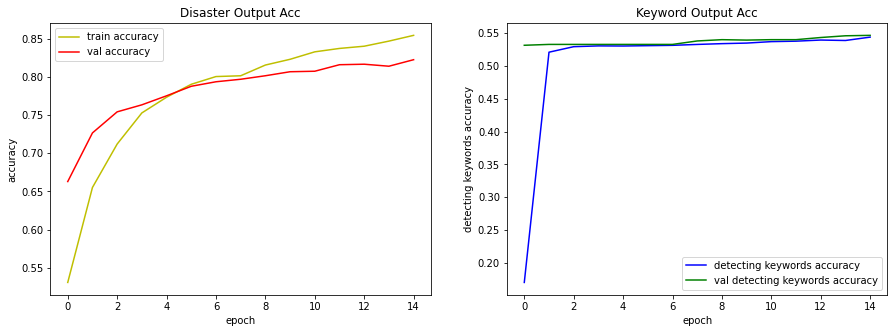

In [0]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(train_history.history['disaster_output_accuracy'], 'y', label='train accuracy')
ax1.plot(train_history.history['val_disaster_output_accuracy'], 'r', label='val accuracy')
ax1.legend()
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.title.set_text("Disaster Output Acc")


ax2.plot(train_history.history['keyword_output_accuracy'], 'b', label='detecting keywords accuracy')
ax2.plot(train_history.history['val_keyword_output_accuracy'], 'g', label='val detecting keywords accuracy')
ax2.legend()
ax2.set_xlabel('epoch')
ax2.set_ylabel('detecting keywords accuracy')
ax2.title.set_text("Keyword Output Acc")


plt.show()

In [0]:
# model.save('Bertmodel.h5')

In [0]:
# cp './Bertmodel.h5' '/content/gdrive/My Drive/Data Mining Project/BertmodelwKeyword4.h5'

## Submission

In [0]:
# load a saved model
model = tf.keras.models.load_model('best_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [0]:
submission=pd.read_csv('./sample_submission.csv')

In [0]:
test_pred, _ = model.predict(test_input)
submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)

In [0]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [0]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "joint learning_v4"

100% 22.2k/22.2k [00:06<00:00, 3.77kB/s]
403 - Your team has used its submission allowance (5 of 5). This resets at midnight UTC (9.0 hours from now).


In [0]:
!cp './submission.csv' '/content/drive/My Drive/Data Mining Project/joint-learning_v4.csv'

In [0]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
